Import the Required packages 

In [1]:
import cv2
import json
import yaml
import numpy as np
import matplotlib.pyplot as plt
import opencv_jupyter_ui as jcv2

Load the Images in Gray-scale, this helps the feature matiching to just focus on the features

In [2]:
# Load the images
imgL = cv2.imread('./Stereo-Camera-Left-Frame2.jpg', cv2.IMREAD_GRAYSCALE)
imgR = cv2.imread('./Stereo-Camera-Right-Frame2.jpg', cv2.IMREAD_GRAYSCALE)

Load and convert Yaml output file of the KalibR toolbox into a json file format

In [3]:
with open("./oak_2024-04-08-10-52-07_0_converted_2024-04-09-14-35-58-camchain.yaml", 'r') as yaml_in, open("./oak_2024-04-08-10-52-07_0_converted_2024-04-09-14-35-58-camchain.json", "w") as json_out:
    yaml_object = yaml.safe_load(yaml_in) # yaml_object will be a list or a dict
    json.dump(yaml_object, json_out)

In [4]:
# Load camera calibration parameters from JSON file
with open('./oak_2024-04-08-10-52-07_0_converted_2024-04-09-14-35-58-camchain.json', 'r') as f:
    calibration_data = json.load(f)

In [5]:
print(calibration_data)

{'cam0': {'cam_overlaps': [1], 'camera_model': 'pinhole', 'distortion_coeffs': [0.3595682049211609, 0.2799452613167447, -0.005572845182351773, 0.005589078008178134], 'distortion_model': 'radtan', 'intrinsics': [596.7375826739508, 597.0778377216482, 329.3072579090607, 237.31223320757667], 'resolution': [640, 480], 'rostopic': '/oak_d_lite/left/image_mono/compressed'}, 'cam1': {'T_cn_cnm1': [[0.9999696225471487, 0.004164140687029577, -0.006588923678911082, -0.07450866484484225], [-0.004169831872755054, 0.9999909447485973, -0.0008502487611280894, -0.00027775177542922063], [0.006585323459090403, 0.0008776976366999126, 0.9999779313373834, -0.0008551555681102787], [0.0, 0.0, 0.0, 1.0]], 'cam_overlaps': [0], 'camera_model': 'pinhole', 'distortion_coeffs': [0.35533974338967517, 0.33185241198948917, -0.00031781526627002723, 0.0012753847775669], 'distortion_model': 'radtan', 'intrinsics': [592.3760711649045, 592.8996741853884, 311.10959871616603, 244.7667424793336], 'resolution': [640, 480], 'ro

Extract the calibration data from the loaded json file into numpy arrays

In [6]:
# Extract calibration parameters for left camera (cam0)
left_intrinsics = np.array(calibration_data['cam0']['intrinsics'])
left_dist_coeffs = np.array(calibration_data['cam0']['distortion_coeffs'])

# Extract calibration parameters for right camera (cam1)
right_intrinsics = np.array(calibration_data['cam1']['intrinsics'])
right_dist_coeffs = np.array(calibration_data['cam1']['distortion_coeffs'])

# Extract relative pose between the two cameras
relative_pose = np.array(calibration_data['cam1']['T_cn_cnm1'])

#pack the camera matrices into standart format 3x3

In [7]:
# Print the extracted calibration parameters
print("Left camera intrinsics:", left_intrinsics)
print("Left camera distortion coefficients:", left_dist_coeffs)
print("Right camera intrinsics:", right_intrinsics)
print("Right camera distortion coefficients:", right_dist_coeffs)
print("Relative pose matrix (T_cn_cnm1):", relative_pose)

Left camera intrinsics: [596.73758267 597.07783772 329.30725791 237.31223321]
Left camera distortion coefficients: [ 0.3595682   0.27994526 -0.00557285  0.00558908]
Right camera intrinsics: [592.37607116 592.89967419 311.10959872 244.76674248]
Right camera distortion coefficients: [ 3.55339743e-01  3.31852412e-01 -3.17815266e-04  1.27538478e-03]
Relative pose matrix (T_cn_cnm1): [[ 9.99969623e-01  4.16414069e-03 -6.58892368e-03 -7.45086648e-02]
 [-4.16983187e-03  9.99990945e-01 -8.50248761e-04 -2.77751775e-04]
 [ 6.58532346e-03  8.77697637e-04  9.99977931e-01 -8.55155568e-04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


Transform the loaded intrinsics into standard format of camera matrix, for further use of the opencv library

In [8]:
cam_matrix_left = np.array([[left_intrinsics[0], 0, left_intrinsics[2]],[0, left_intrinsics[1], left_intrinsics[3]],[ 0, 0, 1]])
cam_matrix_right = np.array([[right_intrinsics[0], 0, right_intrinsics[2]],[0, right_intrinsics[1], right_intrinsics[3]],[ 0, 0, 1]])

In [9]:
print("Left camera matrix:", cam_matrix_left)
print("Right camera matrix:", cam_matrix_right)

Left camera matrix: [[596.73758267   0.         329.30725791]
 [  0.         597.07783772 237.31223321]
 [  0.           0.           1.        ]]
Right camera matrix: [[592.37607116   0.         311.10959872]
 [  0.         592.89967419 244.76674248]
 [  0.           0.           1.        ]]


In [10]:
# Extract relative pose between the two cameras
relative_pose = np.array(calibration_data['cam1']['T_cn_cnm1'])

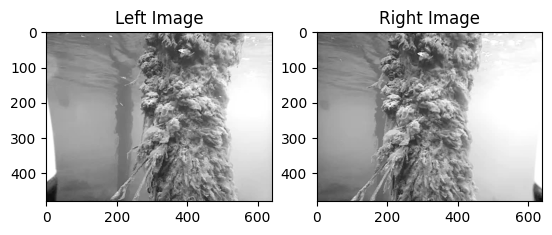

In [11]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(imgL, cmap='gray')
axes[0].set_title('Left Image')
axes[1].imshow(imgR, cmap='gray')
axes[1].set_title('Right Image')
plt.show()

In [12]:
h,  w = imgL.shape[:2]

Obtain the optimal new camera matrix, wich is needed for the apllying of the distortion function of the opencv library and essentially apply the undistortion function on the loaded images

In [13]:
newcameramtxleft, roi=cv2.getOptimalNewCameraMatrix(cam_matrix_left,left_dist_coeffs,(w,h),1)
newcameramtxright, roi=cv2.getOptimalNewCameraMatrix(cam_matrix_right,right_dist_coeffs,(w,h),1)

In [14]:
# Undistort and rectify the left and right image
undistorted_img_left = cv2.undistort(imgL, cam_matrix_left, left_dist_coeffs, None, newcameramtxleft)
undistorted_img_right = cv2.undistort(imgR, cam_matrix_right, right_dist_coeffs, None, newcameramtxright)

Crop the images, and store the results as new images, in png format. Then apply the strong undistort function onto the images 

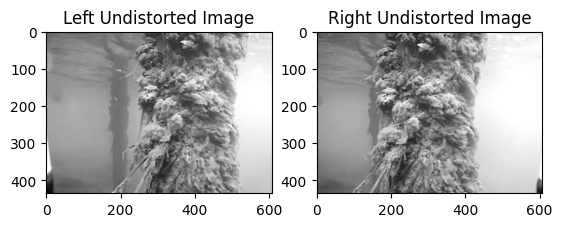

In [15]:
# crop the image left
x, y, w, h = roi
undistorted_img_left = undistorted_img_left[y:y+h, x:x+w]
cv2.imwrite('calibresult-left.png', undistorted_img_left)
 
# crop the image right
x, y, w, h = roi
undistorted_img_right = undistorted_img_right[y:y+h, x:x+w]
cv2.imwrite('calibresult-right.png', undistorted_img_right)

calibL = cv2.imread('calibresult-left.png',cv2.IMREAD_GRAYSCALE)
calibR = cv2.imread('calibresult-right.png',cv2.IMREAD_GRAYSCALE)

fig, axes = plt.subplots(1, 2)
axes[0].imshow(calibL, cmap='gray')
axes[0].set_title('Left Undistorted Image')
axes[1].imshow(calibR, cmap='gray')
axes[1].set_title('Right Undistorted Image')
plt.show()


Now using the undistort mapping function and applying it on to the calibrated pictures

In [16]:
# undistort using strong mapping function
mapxl, mapyl = cv2.initUndistortRectifyMap(cam_matrix_left, left_dist_coeffs, None, newcameramtxleft, (w,h), 5)
dstl = cv2.remap(calibL, mapxl, mapyl, cv2.INTER_LINEAR)

# crop the image left
x, y, w, h = roi
calibL = calibL[y:y+h, x:x+w]
cv2.imwrite('calibresult-left2.png', calibL)

# undistort using strong mapping function
mapxr, mapyr = cv2.initUndistortRectifyMap(cam_matrix_right, right_dist_coeffs, None, newcameramtxright, (w,h), 5)
dstr = cv2.remap(calibR, mapxr, mapyr, cv2.INTER_LINEAR)

# crop the image left
x, y, w, h = roi
calibR = calibR[y:y+h, x:x+w]
cv2.imwrite('calibresult-right2.png', calibR)
 

True

In [17]:
CalibL = cv2.imread('calibresult-left2.png',cv2.IMREAD_GRAYSCALE)
CalibR = cv2.imread('calibresult-right2.png',cv2.IMREAD_GRAYSCALE)

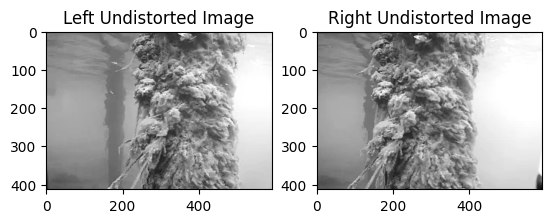

In [18]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(CalibL, cmap='gray')
axes[0].set_title('Left Undistorted Image')
axes[1].imshow(CalibR, cmap='gray')
axes[1].set_title('Right Undistorted Image')
plt.show()

Using feature matching to align the images 


In [19]:
# Initialize SIFT detector
sift = cv2.SIFT_create()

# Detect key points and compute descriptors
keypoints1, descriptors1 = sift.detectAndCompute(CalibL, None)
keypoints2, descriptors2 = sift.detectAndCompute(CalibR, None)

In [31]:
# Draw keypoints on the images
image1_keypoints = cv2.drawKeypoints(CalibL, keypoints1, None)
image2_keypoints = cv2.drawKeypoints(CalibR, keypoints2, None)

# Display the images with keypoints
jcv2.imshow('Image Left with Keypoints', image1_keypoints)
jcv2.imshow('Image Right with Keypoints', image2_keypoints)
jcv2.waitKey(0)
jcv2.destroyAllWindows()

In [32]:
# Initialize the feature matcher using brute-force matching
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

# Match the descriptors using brute-force matching
matches_bf = bf.match(descriptors1, descriptors2)

# Sort the matches by distance (lower is better)
matches_bf = sorted(matches_bf, key=lambda x: x.distance)

# Draw the top N matches
num_matches = 50
image_matches_bf = cv2.drawMatches(CalibL, keypoints1, CalibR, keypoints2, matches_bf[:num_matches], None)

# Initialize the feature matcher using FLANN matching
index_params = dict(algorithm=0, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

# Match the descriptors using FLANN matching
matches_flann = flann.match(descriptors1, descriptors2)

# Sort the matches by distance (lower is better)
matches_flann = sorted(matches_flann, key=lambda x: x.distance)

# Draw the top N matches
image_matches_flann = cv2.drawMatches(CalibL, keypoints1, CalibR, keypoints2, matches_flann[:num_matches], None)

# Display the images with matches
jcv2.imshow('Brute-Force Matching', image_matches_bf)
jcv2.imshow('FLANN Matching', image_matches_flann)
jcv2.waitKey(0)
jcv2.destroyAllWindows()

In [38]:
# Extract the matched keypoints
src_points_bf = np.float32([keypoints1[m.queryIdx].pt for m in matches_bf]).reshape(-1, 1, 2)
dst_points_bf = np.float32([keypoints2[m.trainIdx].pt for m in matches_bf]).reshape(-1, 1, 2)

# Estimate the homography matrix using RANSAC
homography_bf, mask = cv2.findHomography(src_points_bf, dst_points_bf, cv2.RANSAC, 5.0)

# Print the estimated homography matrix
print("Estimated Homography Matrix with Brute Force Matching:")
print(homography_bf)

Estimated Homography Matrix with Brute Force Matching:
[[ 9.63971506e-01 -3.07025254e-03 -8.32412850e+01]
 [-1.70248784e-02  9.67365821e-01  1.50967492e+01]
 [-5.22065876e-05 -1.34741107e-05  1.00000000e+00]]


In [39]:
# Extract the matched keypoints
src_points_flann = np.float32([keypoints1[m.queryIdx].pt for m in matches_flann]).reshape(-1, 1, 2)
dst_points_flann = np.float32([keypoints2[m.trainIdx].pt for m in matches_flann]).reshape(-1, 1, 2)

# Estimate the homography matrix using RANSAC
homography_flann, mask = cv2.findHomography(src_points_flann, dst_points_flann, cv2.RANSAC, 5.0)

# Print the estimated homography matrix
print("Estimated Homography Matrix with Flann Matching:")
print(homography_flann)

Estimated Homography Matrix with Flann Matching:
[[ 9.79038422e-01 -2.01656992e-02 -8.11851166e+01]
 [-2.55053799e-03  9.73754418e-01  1.08323363e+01]
 [ 6.23719323e-06 -5.25853314e-05  1.00000000e+00]]


In [43]:
# Warp the first image using the homography
result_bf = cv2.warpPerspective(CalibL, homography_bf, (CalibR.shape[1], CalibR.shape[0]))

# Blending the warped image with the second image using alpha blending
alpha = 0.5  # blending factor
blended_image_bf = cv2.addWeighted(result_bf, alpha, CalibR, 1 - alpha, 0)



In [46]:
# Warp the first image using the homography
result_flann = cv2.warpPerspective(CalibL, homography_flann, (CalibR.shape[1], CalibR.shape[0]))

# Blending the warped image with the second image using alpha blending
alpha = 0.5  # blending factor
blended_image_flann = cv2.addWeighted(result_flann, alpha, CalibR, 1 - alpha, 0)

Text(0.5, 1.0, 'FLANN Matching')

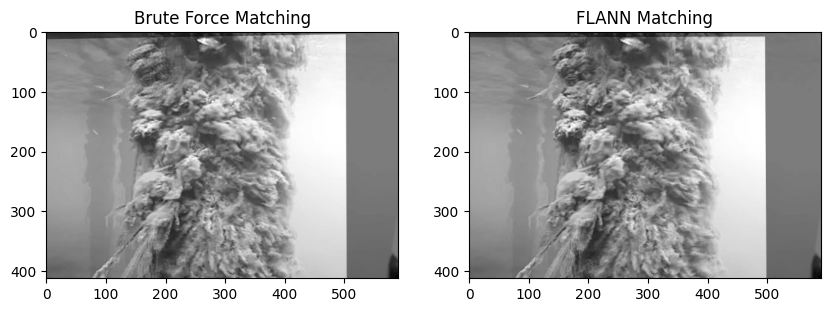

In [48]:
# Display the blended image
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot left image
axes[0].imshow(blended_image_bf, cmap='gray')
axes[0].set_title('Brute Force Matching')

# Plot aligned right image
axes[1].imshow(blended_image_flann, cmap='gray')
axes[1].set_title('FLANN Matching')

In [26]:
# Draw matches
matching_result = cv2.drawMatches(CalibL, keypoints1, aligned_img_right, keypoints2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

In [28]:
# Apply image segmentation to isolate the pillar
# (e.g., using thresholding or other techniques)

<!-- IDK dont mind the part from here. -->

In [73]:
# Detect edges of the pillar
edges = cv2.Canny(undistorted_img_left, threshold1, threshold2)


NameError: name 'threshold1' is not defined

In [ ]:
# Find contours of the detected edges
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


In [ ]:
# Measure diameter of the pillar
for contour in contours:
    (x, y), radius = cv2.minEnclosingCircle(contour)
    diameter = radius * 2
    # Optionally, convert pixel measurement to physical measurement using scale information


In [ ]:

# Display the measured diameter
print("Diameter of the pillar:", diameter)